In [4]:
import os
import sys
import numpy as np
import pickle
from tqdm import tqdm
import networkx as nx

from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx

## Data Loading

In [5]:
target_sid = 1210005301
dataset = '{}_mtsc'.format(target_sid)

train = np.load('/media/usr/SSD/jiin/naver/Automatic_Incident_Detection/data/{}/train.npz'.format(dataset))
val = np.load('/media/usr/SSD/jiin/naver/Automatic_Incident_Detection/data/{}/val.npz'.format(dataset))
test = np.load('/media/usr/SSD/jiin/naver/Automatic_Incident_Detection/data/{}/test.npz'.format(dataset))


In [6]:
H = nx.read_gpickle("/media/usr/SSD/jiin/naver/Automatic_Incident_Detection/data/{}/sensor_graph.gpickle".format(dataset))

In [7]:
train['x'].shape, train['y'].shape

((5296, 12, 25), (5296,))

In [8]:
test['x'].shape, test['y'].shape

((1708, 12, 25), (1708,))

In [9]:
np.unique(train['y'], 
          return_counts = True) 

(array([0, 1]), array([5178,  118]))

In [10]:
np.unique(test['y'], 
          return_counts = True) 

(array([0, 1]), array([1401,  307]))

In [11]:
train['x'].reshape(train['x'].shape[0], -1).shape

(5296, 300)

In [12]:
def evaluate(true, pred, score, adjust = False, plot=False, print_=False):
#     true = label_all
#     pred = list(map(int, [s>0 for s in score_all]))
    # if adjust:
    #     pred = adjust_predictions(pred, true)
    CM = confusion_matrix(true, pred)
    TN = CM[0][0]
    FN = CM[1][0]
    TP = CM[1][1]
    FP = CM[0][1]
    acc = accuracy_score(true, pred)
    # auc = roc_auc_score(true, pred)
    auc = roc_auc_score(true, score)
#     far = FP / (FP+TN)
    far = FP / (TP+FP)
    pre = precision_score(true, pred, pos_label=1)
    rec = recall_score(true, pred, pos_label=1)
    macro_f1 = f1_score(true, pred, average='macro')
    weighted_f1 = f1_score(true, pred, average='weighted')
    ap = average_precision_score(true, score)
    # ap = average_precision_score(true, pred)
    if plot:
        plt.figure(figsize=(40, 5))
        plt.plot(true)
        plt.plot(pred)
    if print_:
        print('Accuracy \t{:.4f}'.format(acc))
        print('AUC score \t{:.4f}'.format(auc))
        print('FAR score \t{:.4f}'.format(far))
        print('Precision \t{:.4f}'.format(pre))
        print('Recall   \t{:.4f}'.format(rec))
        print('Macro F1 \t{:.4f}'.format(macro_f1))
        print('weighted F1 \t{:.4f}'.format(weighted_f1))
        print('Avg Precision \t{:.4f}'.format(ap))
        print(classification_report(true, pred))
    return [acc, auc, far, pre, rec, macro_f1, weighted_f1, ap]


## SVM

In [11]:
from sklearn.svm import SVC

clf = SVC(probability=True)
clf.fit(train['x'].reshape(train['x'].shape[0], -1), train['y'])

SVC(probability=True)

In [12]:
true = test['y']
pred = clf.predict(test['x'].reshape(test['x'].shape[0], -1))
score = clf.predict_proba(test['x'].reshape(test['x'].shape[0], -1))[:, 1]

In [13]:
pred.shape

(1708,)

In [14]:
print(classification_report(true, pred))
print(roc_auc_score(true, pred))
print(roc_auc_score(true, score))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1401
           1       1.00      0.69      0.82       307

    accuracy                           0.94      1708
   macro avg       0.97      0.85      0.89      1708
weighted avg       0.95      0.94      0.94      1708

0.8452768729641693
0.9587986245283149


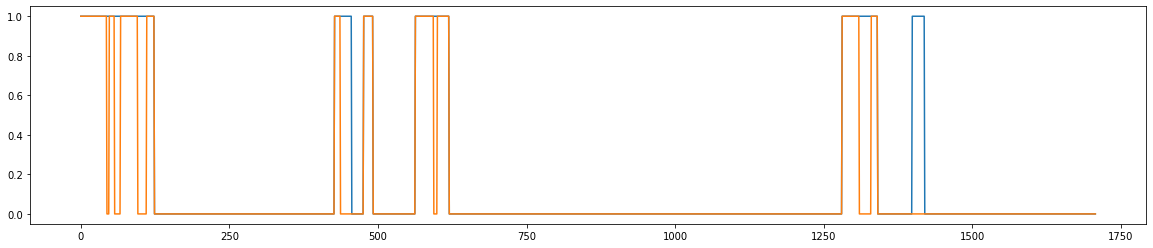

In [15]:
plt.figure(figsize=(20,4))
plt.plot(true)
plt.plot(pred)

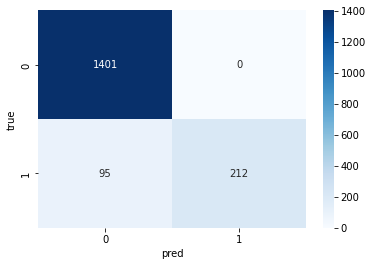

In [14]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## MLP

In [10]:
### MLP
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(hidden_layer_sizes=(64, 64))
clf.fit(train['x'].reshape(train['x'].shape[0], -1), train['y'])

MLPClassifier(hidden_layer_sizes=(64, 64))

In [11]:
true = test['y']
pred = clf.predict(test['x'].reshape(test['x'].shape[0], -1))
score = clf.predict_proba(test['x'].reshape(test['x'].shape[0], -1))[:, 1]

print(classification_report(true, pred))
print(roc_auc_score(true, pred), roc_auc_score(true, score))
print(average_precision_score(true, pred), average_precision_score(true, score))

              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1401
           1       1.00      0.63      0.77       307

    accuracy                           0.93      1708
   macro avg       0.96      0.82      0.87      1708
weighted avg       0.94      0.93      0.93      1708

0.8159609120521172 0.9949454438081686
0.6980810746897146 0.9815084987308674


In [12]:
clf.predict_proba(test['x'].reshape(test['x'].shape[0], -1))[:, 1]

array([9.96119883e-01, 9.96403387e-01, 9.96720667e-01, ...,
       9.74478983e-09, 9.50875425e-08, 7.82784739e-07])

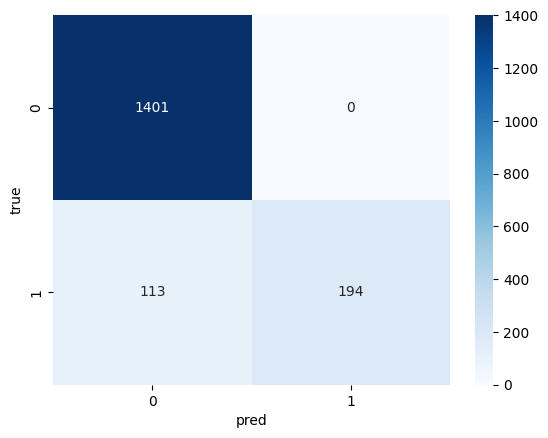

In [13]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## OCSVM

In [14]:
# DATA
train_data = train['x'].reshape(train['x'].shape[0], -1)  ## (n_samples, seq_len * n_node)
test_data = test['x'].reshape(test['x'].shape[0], -1)

train_label = train['y']
test_label = test['y']

In [15]:
## OCSVM
print('Multivariate OCSVM')
from sklearn.svm import OneClassSVM

clf = OneClassSVM(kernel='rbf').fit(train_data)

true = test_label
pred = clf.predict(test_data)
pred = [1 if p == -1 else 0 for p in pred]
score = clf.decision_function(test_data)
score = score 

acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(true, pred, score, adjust=False, plot=False, print_=True)
# result_all.append(['multivariate', 'OCSVM', rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

Multivariate OCSVM
Accuracy 	0.5439
AUC score 	0.1457
FAR score 	0.7173
Precision 	0.2827
Recall   	1.0000
Macro F1 	0.5279
weighted F1 	0.5836
Avg Precision 	0.1050
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      1401
           1       0.28      1.00      0.44       307

    accuracy                           0.54      1708
   macro avg       0.64      0.72      0.53      1708
weighted avg       0.87      0.54      0.58      1708



In [16]:
np.unique(clf.predict(test_data))

array([-1,  1])

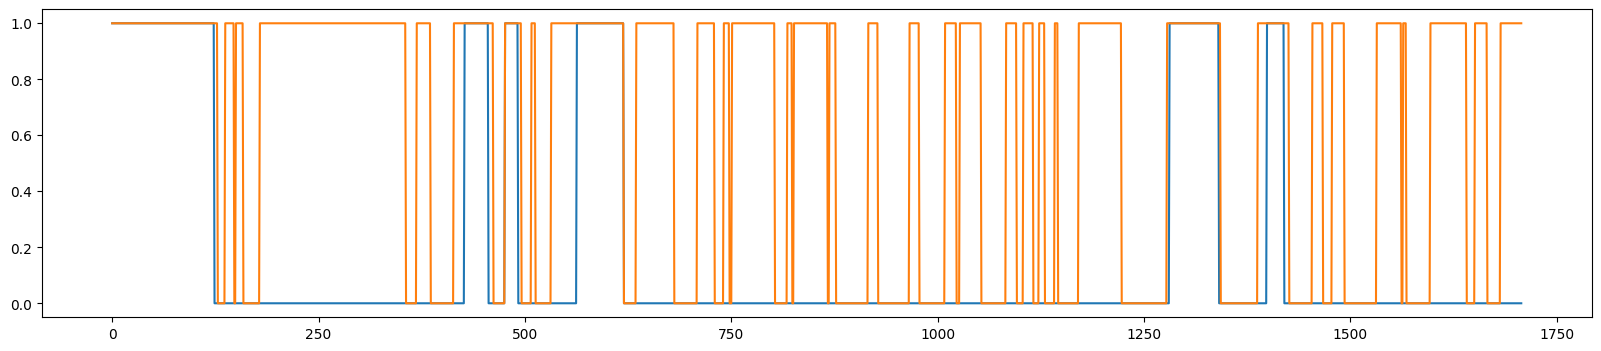

In [17]:
plt.figure(figsize=(20,4))
plt.plot(true)
plt.plot(pred)

## CNN

In [18]:
np.transpose(train['x'], (0, 2, 1)).shape

(5296, 25, 12)

In [19]:
np.unique(train['y'])

array([0, 1])

In [22]:
from sktime.classification.deep_learning import CNNClassifier

clf = CNNClassifier(n_epochs=10, batch_size=64, random_state=0)
clf.fit(np.transpose(train['x'], (0, 2, 1)), train['y'])

/home/jiin/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023-05-28 14:48:48.687413: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:48:48.687653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-28 14:48:48.688113: W ten

CNNClassifier(batch_size=64, n_epochs=10, random_state=0)

In [23]:
true = test['y']
pred = clf.predict(np.transpose(test['x'], (0, 2, 1)))

print(classification_report(true, pred))

27/27 [==============================] - 0s 888us/step
              precision    recall  f1-score   support

           0       0.92      1.00      0.96      1401
           1       1.00      0.58      0.73       307

    accuracy                           0.92      1708
   macro avg       0.96      0.79      0.85      1708
weighted avg       0.93      0.92      0.92      1708



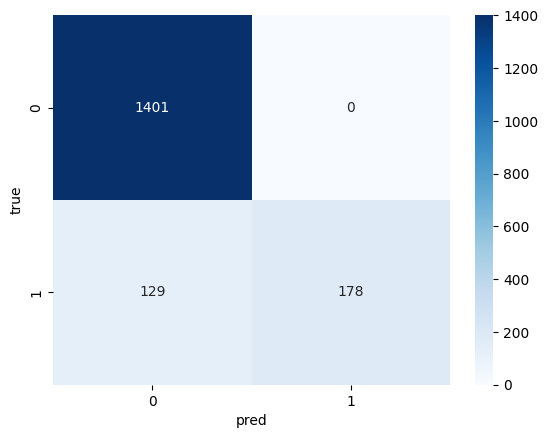

In [24]:
cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('pred')
plt.ylabel('true')
plt.show()

## LSTM FCN

In [25]:
from sktime.classification.deep_learning import LSTMFCNClassifier

clf = LSTMFCNClassifier(n_epochs=10, batch_size=64, random_state=0, verbose=True)
clf.fit(np.transpose(train['x'], (0, 2, 1)), train['y'])

/home/jiin/anaconda3/envs/tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
2023-05-28 14:52:31.937337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 14:52:31.938129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype in

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 12, 25)]     0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 12, 128)      25728       ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 128)     512         ['conv1d_2[0][0]']               
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 12, 128)      0           ['batch_normalization[0][0]

2023-05-28 14:52:32.224495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-28 14:52:32.225510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-28 14:52:32.226234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

83/83 [==============================] - 3s 11ms/step - loss: 0.1508 - accuracy: 0.9413
Epoch 2/10
83/83 [==============================] - 1s 11ms/step - loss: 0.0135 - accuracy: 0.9985
Epoch 3/10
83/83 [==============================] - 1s 11ms/step - loss: 0.0069 - accuracy: 0.9989
Epoch 4/10
83/83 [==============================] - 1s 11ms/step - loss: 0.0035 - accuracy: 0.9998
Epoch 5/10
83/83 [==============================] - 1s 11ms/step - loss: 0.0019 - accuracy: 1.0000
Epoch 6/10
83/83 [==============================] - 1s 11ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 7/10
46/83 [===============>..............] - ETA: 0s - loss: 0.0015 - accuracy: 1.0000

KeyboardInterrupt: 

In [59]:
true = test['y']
pred = clf.predict(np.transpose(test['x'], (0, 2, 1)))

print(classification_report(true, pred))

16/27 [================>.............] - ETA: 0s

2023-05-27 20:42:14.833699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-05-27 20:42:14.834677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-05-27 20:42:14.835299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

27/27 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      1401
           1       1.00      0.73      0.85       307

    accuracy                           0.95      1708
   macro avg       0.97      0.87      0.91      1708
weighted avg       0.95      0.95      0.95      1708



In [ ]:
from sktime.classification.hybrid import HIVECOTEV2

hc2 = HIVECOTEV2(time_limit_in_minutes=0.2)
hc2.fit(np.transpose(train['x'], (0, 2, 1)), train['y'])


true = test['y']
pred = hc2.predict(np.transpose(test['x'], (0, 2, 1)))

print(classification_report(true, pred))

## DeepSAD

In [19]:
# DATA
train_data = train['x'].reshape(train['x'].shape[0], -1)  ## (n_samples, seq_len * n_node)
test_data = test['x'].reshape(test['x'].shape[0], -1)

train_label = np.where(train['y']==1, -1, train['y'])
test_label = np.where(test['y']==1, -1, test['y'])   ## -1 is known anomaly, 0 is unknown, 1 is known normal

In [21]:
np.unique(train_label), np.unique(test_label)

(array([-1,  0]), array([-1,  0]))

In [22]:
from deepod.models.dsad import DeepSAD

In [39]:
clf = DeepSAD(epochs=100, rep_dim=128, device='cpu', random_state=0)
clf.fit(train_data, train_label)

TypeError: __init__() got an unexpected keyword argument 'network'

In [34]:
pred = clf.predict(test_data)
scores = clf.decision_function(test_data)
scores

array([1.95680151e+03, 2.07798584e+03, 2.05849072e+03, ...,
       3.59885255e-03, 6.83882798e-04, 7.11801520e-04])

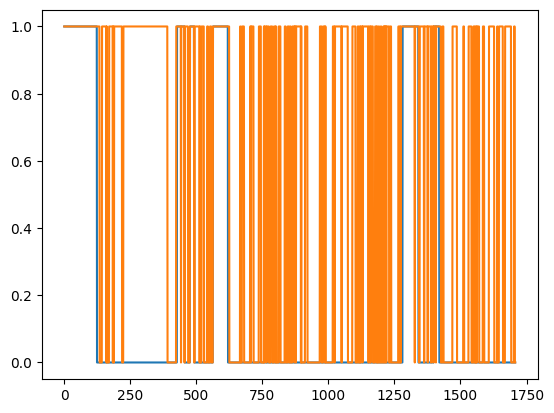

In [35]:
plt.plot(test['y'])
plt.plot(pred)

In [36]:
true = test['y']
pred = clf.predict(test_data)
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.99      0.45      0.62      1401
           1       0.28      0.99      0.44       307

    accuracy                           0.55      1708
   macro avg       0.64      0.72      0.53      1708
weighted avg       0.87      0.55      0.59      1708



In [38]:
evaluate(true, pred, scores, adjust=False, plot=False, print_=True)

Accuracy 	0.5498
AUC score 	0.9577
FAR score 	0.7163
Precision 	0.2837
Recall   	0.9870
Macro F1 	0.5320
weighted F1 	0.5904
Avg Precision 	0.8964
              precision    recall  f1-score   support

           0       0.99      0.45      0.62      1401
           1       0.28      0.99      0.44       307

    accuracy                           0.55      1708
   macro avg       0.64      0.72      0.53      1708
weighted avg       0.87      0.55      0.59      1708



[0.5497658079625293,
 0.9577012231839984,
 0.7162921348314607,
 0.28370786516853935,
 0.9869706840390879,
 0.5319755912876932,
 0.5904215283515691,
 0.8964406681776111]

## DevNet

In [40]:
from deepod.models.devnet import DevNet

In [42]:
# DATA
train_data = train['x'].reshape(train['x'].shape[0], -1)  ## (n_samples, seq_len * n_node)
test_data = test['x'].reshape(test['x'].shape[0], -1)

train_label = train['y']
test_label = test['y']

In [44]:
clf = DevNet(epochs=100, batch_size=64, device='cpu')
clf.fit(train_data, y=train_label)
scores = clf.decision_function(test_data)

Start Training...
ensemble size: 1
MLPnet(
  (network): Sequential(
    (0): LinearBlock(
      (linear): Linear(in_features=300, out_features=100, bias=False)
      (act_layer): ReLU()
    )
    (1): LinearBlock(
      (linear): Linear(in_features=100, out_features=50, bias=False)
      (act_layer): ReLU()
    )
    (2): LinearBlock(
      (linear): Linear(in_features=50, out_features=1, bias=False)
      (act_layer): Identity()
    )
  )
)
epoch1, training loss: 2.502380, time: 0.0s
epoch10, training loss: 2.274353, time: 0.0s
epoch20, training loss: 2.710418, time: 0.0s
epoch30, training loss: 2.768438, time: 0.0s
epoch40, training loss: 2.268364, time: 0.0s
epoch50, training loss: 2.500000, time: 0.0s
epoch60, training loss: 2.736339, time: 0.0s
epoch70, training loss: 2.500000, time: 0.0s
epoch80, training loss: 2.733182, time: 0.0s
epoch90, training loss: 2.454918, time: 0.0s
epoch100, training loss: 2.581043, time: 0.0s
Start Inference on the training data...


In [45]:
true = test['y']
pred = clf.predict(test_data)
score = clf.decision_function(test_data)

acc, auc, far, pre, rec, macro_f1, weight_f1, ap = evaluate(true, pred, score, adjust=False, plot=False, print_=False)
# result_all.append(['multivariate', 'DeepSAD', rec, far, pre, rec, acc, auc, macro_f1, weight_f1, ap])

In [46]:
evaluate(true, pred, scores, adjust=False, plot=False, print_=True)

Accuracy 	0.7096
AUC score 	0.4168
FAR score 	0.8387
Precision 	0.1613
Recall   	0.1466
Macro F1 	0.4892
weighted F1 	0.7041
Avg Precision 	0.1600
              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1401
           1       0.16      0.15      0.15       307

    accuracy                           0.71      1708
   macro avg       0.49      0.49      0.49      1708
weighted avg       0.70      0.71      0.70      1708



[0.7096018735362998,
 0.4168148855982348,
 0.8387096774193549,
 0.16129032258064516,
 0.1465798045602606,
 0.4891593000397978,
 0.7041006328429823,
 0.1599993915209027]